In [1]:
import json
import os
import argparse
import sys

import torch
from torch import nn, optim
from torch.nn import functional as F
from LSTM_cos import Convolution_LSTM_cos as model

sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(""))))
import commons
import utils
from utils import load_filepaths_and_text, load_wav_to_torch

In [2]:
def audio_processing(audio_path, hps):
    audio, sr = load_wav_to_torch(audio_path)
    audio_norm = audio/ hps.data.max_wav_value
    audio_norm = audio_norm.unsqueeze(0)
    stft = commons.TacotronSTFT(hps.data.filter_length, hps.data.hop_length, 
                               hps.data.win_length, hps.data.n_mel_channels, 
                               hps.data.sampling_rate, hps.data.mel_fmin,
                               hps.data.mel_fmax)
    melspec = stft.mel_spectrogram(audio_norm)
    melspec = torch.squeeze(torch.tensor(melspec),0)
    melspec = torch.abs(melspec)
    
    frames = hps.data.slice_length
    mel_padded = torch.FloatTensor(1, hps.data.n_mel_channels, frames)
    mel_padded.zero_()
    if melspec.size(1) < frames:
        mel_padded[:, :, :melspec.size(1)] = melspec
    else : 
        mel_padded[:, :, :frames] = melspec[:, :frames]
    return mel_padded/torch.max(mel_padded)

In [3]:
saved_model_path = "/media/caijb/data_drive/autoencoder/log/kernel5_conv_LSTM_trans"
config_path = os.path.join(saved_model_path, "config.json")
with open(config_path,"r") as f:
        data = f.read()
config = json.loads(data)
hps = utils.HParams(**config)


checkpoint_path = utils.latest_checkpoint_path(saved_model_path)

CAC = model(encoder_dim = hps.data.slice_length, hidden_dim1= hps.model.hidden_dim1,
    hidden_dim2=hps.model.hidden_dim2, hiddem_dim3= hps.model.hidden_dim3,
    l_hidden=hps.model.l_hidden, num_layers=hps.model.num_layers, embedding_size=hps.model.embedding_size)

CAC, _, _, _ = utils.load_checkpoint(checkpoint_path, CAC)

/media/caijb/data_drive/autoencoder/log/kernel5_conv_LSTM_trans/G_8.pth
INFO:root:Loaded checkpoint '/media/caijb/data_drive/autoencoder/log/kernel5_conv_LSTM_trans/G_8.pth' (iteration 8)


In [4]:
text_path = "/media/caijb/data_drive/data/Zeroshot/vctk_tester.txt"
with open(text_path, "r") as f:
    data = f.read()
    data = data.split("\n")

    
result = []
for i in data:
    i = i.split("|")
    audio_path, sid = i[0], i[1]
    print(audio_path)
    mel = audio_processing(audio_path, hps)
    vector = CAC(mel)
    vector = vector.squeeze()
    temp_vector = vector.tolist()
    temp_vector.append(int(sid))
    result.append(temp_vector)


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_009.wav


/home/caijb/Desktop/zero_shot_glowtts/stft.py:68: FutureWarning: Pass size=1024 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  fft_window = pad_center(fft_window, filter_length)
/home/caijb/Desktop/zero_shot_glowtts/commons.py:172: FutureWarning: Pass sr=22050, n_fft=1024, n_mels=80, fmin=0.0, fmax=8000.0 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_010.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_020.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_021.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_030.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_033.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_046.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_049.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_060.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_061.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_072.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_073.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_094.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_103.wav
/media/caijb/data_drive/data/vctk/VCTK-Corpus/wav48/p225/p225_116.wav
/media/caijb/data_dr

In [5]:
import pandas as pd

df = pd.DataFrame(result)
df.to_csv("./result_unseen_trans.csv")

In [6]:
import matplotlib.pyplot as plt
df.head()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
0,-1.153175,1.622893,-3.561132,-2.135277,2.689821,3.260158,-4.930698,5.827763,7.187327,4.874224,...,-6.632195,-3.009639,3.700776,11.247460,-1.414267,1.514251,3.613792,-7.277318,4.942262,2
1,0.726479,4.695060,11.288475,1.458318,-0.260231,-3.089035,1.320409,4.956947,-4.882248,-5.155776,...,3.349324,6.221917,2.570797,0.813920,-0.361338,5.899799,1.915410,2.700787,5.405408,2
2,0.626897,4.410467,10.717540,1.128226,-0.123539,-2.489626,1.094198,4.732118,-4.174872,-4.789556,...,2.710549,5.591446,2.838598,1.381216,-0.452580,5.522750,1.918659,2.136997,5.253949,2
3,0.610014,4.145328,11.161426,1.359558,-0.143683,-2.768194,1.348944,4.161533,-4.909716,-5.173923,...,3.524471,5.969258,2.361958,0.199555,-0.279780,5.302388,1.544824,2.802022,4.718475,2
4,-0.990705,4.177992,-1.331501,0.081294,0.706707,4.368757,-7.171439,1.306234,8.206201,3.856789,...,-1.799929,-4.517168,2.732136,6.967339,-0.266548,5.949340,1.768176,-3.913634,5.426069,2


In [7]:
y = df[[256]]
"""
y =y.replace(125,0)
y =y.replace(124,1)
y =y.replace(113,2)
y =y.replace(115,3)
y =y.replace(114,4)

"""
y =y.replace(2,0)
y =y.replace(3,1)
y =y.replace(4,2)
y =y.replace(5,3)
y =y.replace(6,4)

x = df.drop([256],axis =1)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

In [9]:
from sklearn.decomposition import PCA
pca =PCA(n_components = 2)
pca.fit(x)
x_pca = pca.transform(x)
x_pca= pd.DataFrame(x_pca)
x_pca['target']=y

In [10]:
markers = ['o', '^', 's', 'x','p']
name = ['jing Li', 'Bart de Leeuw','Tux', 'Harri Tapani Ylilammi', 'Gilles G.Le Blanc']
sid_list = [125, 124, 113, 115, 114]

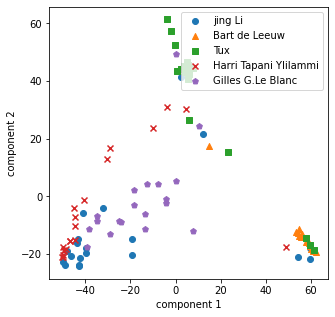

In [11]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_pca[x_pca['target']==i][0]
    y_axis = x_pca[x_pca['target']==i][1]
    
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='upper right')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()

In [12]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda= LinearDiscriminantAnalysis(n_components =2)
#scaler = StandardScaler()
#x_scaled = scaler.fit_transform(x)
lda.fit(x_scaled,y)
x_lda = lda.transform(x_scaled)
x_lda = pd.DataFrame(x_lda)
x_lda['target'] = y

/home/caijb/anaconda3/envs/pytts/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


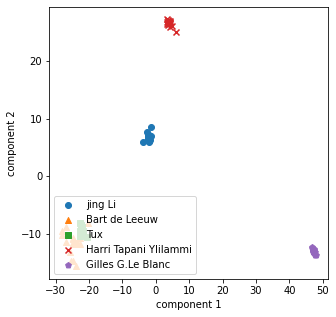

In [13]:
fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
for i, marker in enumerate(markers) :
    x_axis = x_lda[x_lda['target']==i][0]
    y_axis = x_lda[x_lda['target']==i][1]
    plt.scatter(x_axis,y_axis, marker=marker, label = name[i])

plt.legend(loc='lower left')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()